In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math


from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs)
from mne.preprocessing import Xdawn
from dataset import EEG


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
sys.path.append(os.path.abspath(os.path.join('..')))
# Now do your import
from config import *

In [2]:
#runs =[[3,5,7,9],[4,6,8,10],[3,4,5,6,7,8,9,10]]
#session 1
#runs =[[3,5],[4,6],[3,4,5,6]]
#session 2
#runs = [[7,9],[8,10],[7,8,9,10]]
#runs_name = ['EX','MI',"ALL"]
#runs = [[4,6,8,10,12],[3,5,7,9,11]]
#runs = [[26,27,28,29,30]]
#runs_name = ['Foot MI','Hand MI']
runs = [[19]]
runs_name = ['Resting']
subjects = [21]

freqs = np.arange(8, 13)  # frequencies from 2-35Hz
vmin, vmax = -10, 10  # set min and max ERDS values in plot
baseline = (-3,0)  # baseline interval (in s)
tmin, tmax = -3,5
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}

path = RECORED_PATH
base_url = 'https://physionet.org/files/eegmmidb/'
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta','gamma']

**************** Resting **********
**************** [19] **********
/Users/pongkornsettasompop/Desktop/work/Motor-Imagery/EEG-python/dataset/recorded_EEG
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
Applying baseline correction (mode: percent)
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...
       condition epoch  freq   time channel ch_type     value
0              1     1   8.0 -3.000      T3     eeg  3.148939
1              1     1   8.0 -3.000      C3     eeg  4.712150
2              1     1   8.0 -3.000      C4     eeg  1.160391
3              1     1   8.0 -3.000      T4     eeg  3.276607
4              1     1   8.0 -2.996      T3     eeg  3.161161
...          ...   ...   ...    ...     ...     ...       ...
800395         2    39  12.0  4.996      T4     eeg -0.936712
800396         2    39  12.0  5.000      T3     eeg -0.389303
800397         2    39  12.0  5.000      C3     eeg -0.477220
800398         2    39  12.0  5.000      C4     eeg -0.910445
800399         2    

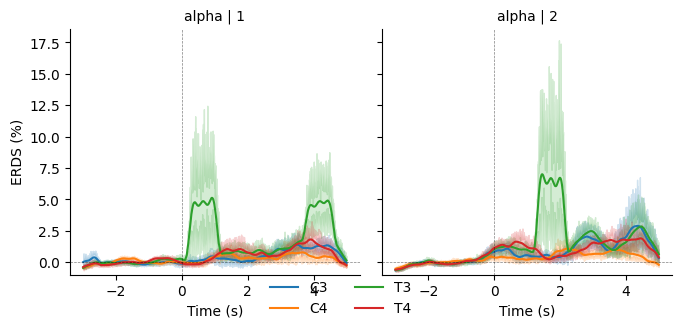

In [3]:
for i in range(len(runs)):
    print('**************** {} **********'.format(runs_name[i]))
    print('**************** {} **********'.format(runs[i]))
    eeg = EEG(path,subjects, runs[i])
    raw=eeg.data_to_raw()
    raw=raw.notch_filter([50])
    raw=raw.filter(8,13, method='fir', verbose="error")
    #print("HELLO")
    #print(raw.info['ch_names'])
    raw.pick_channels(['T3','C3','C4','T4','STIM MARKERS'])
    
    epochs=eeg.epochs(raw,tmin=tmin,tmax=tmax,event_id=[1,2],baseline=baseline) 
    event_ids = epochs.event_id
    
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                  buffer_size=None, out_type='mask')  # for cluster test
    
    
    
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,return_itc=False, average=False, decim=1)
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
    df = tfr.to_data_frame(time_format=None, long_format=True)
    print(df)
    df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])
    

    
    df = df[df.band.isin(freq_bands_of_interest)]

    df['band'] = df['band'].cat.remove_unused_categories()

    # Order channels for plotting:
    #df['channel'] = df['channel'].cat.reorder_categories(('C3','C4','Cz'),
       #                                                  ordered=True)
    #FIX DYNAMIC PLEASE
    g = sns.FacetGrid(df, row='band', col='condition')
    g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
    axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)
    print(np.max(df.value))
    #watch this
    g.set(ylim=(-1, None))
    g.set_axis_labels("Time (s)", "ERDS (%)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.add_legend(ncol=2, loc='lower center')
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    
    g.savefig("./ERD/{0}_ERD_S{1}.png".format(runs_name[i],subjects[0])) 
    g.fig#.clf()

## Lapacian

In [4]:
raw_csd = mne.preprocessing.compute_current_source_density(raw)
raw_csd.plot()

RuntimeError: Cannot fit headshape without digitization , info["dig"] is None